In [1]:
#Following the tutorial from https://github.com/python-engineer/tensorflow-course/blob/master/08_09_Star_Wars_Project.ipynb

import os
import math
import random
import shutil
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
BASE_DIR = 'lego/star-wars-images/'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]

tf.random.set_seed(1)

In [3]:
# Load the model from the pretrained ones
vgg16_model = tf.keras.applications.vgg16.VGG16()
#vgg16_model.summary()

#resnet_model = tf.keras.applications.ResNet50()
#resnet_model.summary()

#incepV3_model = tf.keras.applications.InceptionV3()
#incepV3_model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-10-28 13:40:43.976212: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-28 13:40:43.976329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# Convert to Sequential model, omit the last layer

# // This works with VGG16 because the structure is linear, if not, then other techniques have to be applied
model_vgg16 = keras.models.Sequential()
for layer in vgg16_model.layers[0:-1]:
    model_vgg16.add(layer)
model_vgg16.summary()

# Set trainable=False for all layers
# //we don't want to train them again so we freeze them
for layer in model_vgg16.layers:
    layer.trainable = False
# Add a last classification layer for our use case with 5 classes
model_vgg16.add(layers.Dense(5))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [5]:
# loss and optimizer
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

# Set up our models
model_vgg16.compile(optimizer=optim, loss=loss, metrics=metrics)

In [6]:
# get the preprocessing function of this model // The same funtion works for ResNet
preprocess_input = tf.keras.applications.vgg16.preprocess_input

# Generate batches of tensor image data with real-time data augmentation.

train_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
valid_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = train_gen.flow_from_directory(
    'lego/star-wars-images/train',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names   
)

val_batches = valid_gen.flow_from_directory(
    'lego/star-wars-images/val',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=True,
    color_mode="rgb",
    classes=names
)

test_batches = test_gen.flow_from_directory(
    'lego/star-wars-images/test',
    target_size=(224, 224),
    class_mode='sparse',
    batch_size=4,
    shuffle=False,
    classes=names
)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [7]:
# Fit the model

epochs = 30
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)
#early_stopping2 = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,verbose=2)

# Train the VGG model
print('*************TRAINING THE VGG16 MODEL*************')
history_vgg16 = model_vgg16.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

*************TRAINING THE VGG16 MODEL*************
Epoch 1/30


2022-10-28 13:40:46.526018: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-28 13:40:46.842095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-28 13:40:47.975715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 - 2s - loss: 1.7269 - accuracy: 0.4054 - val_loss: 0.7193 - val_accuracy: 0.6875 - 2s/epoch - 182ms/step
Epoch 2/30
10/10 - 1s - loss: 0.1884 - accuracy: 0.9730 - val_loss: 0.5689 - val_accuracy: 0.8750 - 1s/epoch - 110ms/step
Epoch 3/30
10/10 - 1s - loss: 0.0210 - accuracy: 1.0000 - val_loss: 0.4680 - val_accuracy: 0.8750 - 1s/epoch - 109ms/step
Epoch 4/30
10/10 - 1s - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.4310 - val_accuracy: 0.8750 - 1s/epoch - 110ms/step
Epoch 5/30
10/10 - 1s - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.3974 - val_accuracy: 0.8750 - 1s/epoch - 108ms/step
Epoch 6/30
10/10 - 1s - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.3818 - val_accuracy: 0.8750 - 1s/epoch - 109ms/step
Epoch 7/30
10/10 - 1s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.3739 - val_accuracy: 0.8750 - 1s/epoch - 110ms/step
Epoch 8/30
10/10 - 1s - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.3688 - val_accuracy: 0.8750 - 1s/epoch - 109ms/step
Epoch 9/30
10/10 - 1s - loss: 0.001

In [8]:
model_vgg16.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 0.0148 - accuracy: 1.0000 - 248ms/epoch - 83ms/step


[0.01477306243032217, 1.0]

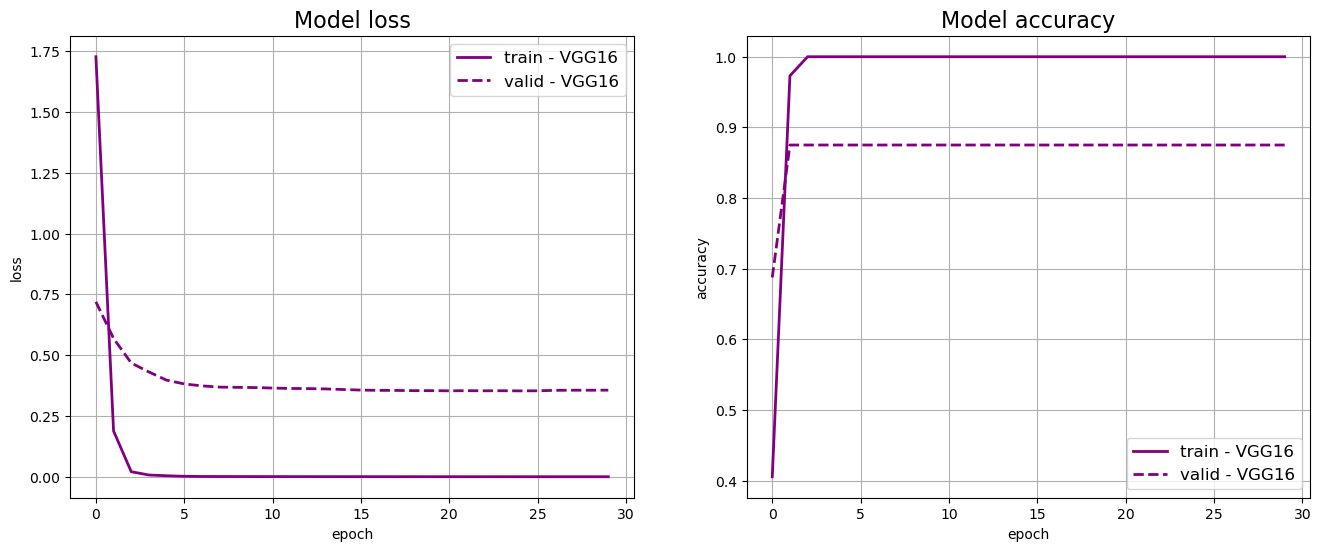

In [9]:
# Plots for loss and acc
from turtle import color


plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='train - VGG16', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16.history['val_loss'], label='valid - VGG16', color = 'purple', linestyle='--',
        linewidth=2)
#plt.plot(history_resnet50.history['loss'], label='train - RN50', color = 'darkturquoise', linestyle='-',
#        linewidth=2)
#plt.plot(history_resnet50.history['val_loss'], label='valid - RN50', color = 'darkturquoise', linestyle='--',
#        linewidth=2)
plt.title('Model loss', fontdict={'size': 16})  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.grid()
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='train - VGG16', color = 'purple', linestyle='-',
        linewidth=2)
plt.plot(history_vgg16.history['val_accuracy'], label='valid - VGG16', color = 'purple', linestyle='--',
        linewidth=2)
#plt.plot(history_resnet50.history['accuracy'], label='train - RN50', color = 'darkturquoise', linestyle='-',
#        linewidth=2)
#plt.plot(history_resnet50.history['val_accuracy'], label='valid - RN50', color = 'darkturquoise', linestyle='--',
#        linewidth=2)
plt.title('Model accuracy',fontdict={'size': 16})  
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.grid()
plt.legend(fontsize=12)

In [10]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        imgBGR = batch[0][i]
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        plt.imshow(imgRGB)
        #plt.imshow(batch[0][i])#, cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

In [11]:
def show2(batch, test_directory, pred_labels=None):
    for i in range(0,len(batch)):
        imgBGR = cv2.imread(test_directory, test_batches.filenames[i])
        imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
        plt.imshow(imgRGB)
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()


In [12]:
# make some predictions
predictions = model_vgg16.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(f'Predicted labels: {test_batches[0][1]}') #Predicted labels
print(f'Real labels: {labels[0:4]}') #Real labels

test_direcory = 'lego/star-wars-images/test'
batch = test_batches[0]
#show(test_batches[0], labels[0:4])
#show2(batch, test_direcory, labels[0:4])

1/3 [=========>....................] - ETA: 0s

2022-10-28 13:41:20.611137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 83ms/step
Predicted labels: [0. 0. 1. 1.]
Real labels: [0 0 1 1]
